In [30]:
import pandas as pd 
import numpy as np
from lightgbm import LGBMRegressor 
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings 
from sklearn.metrics import mean_squared_error
import lofo
from sklearn.model_selection import StratifiedGroupKFold
import seaborn as sns
from sklearn.ensemble import VotingRegressor

In [31]:
warnings.filterwarnings('ignore')

In [32]:
#calculates a statistic of a variable by another variable (like getting the average weight(feature 1) for males and female (by sex which is feature 2) )
def stats_by_feat(train,test,feat_to_stat,feat_to_group,func):
    for df in (train,test):
        df[feat_to_stat+feat_to_group+func] = df[feat_to_group].map(df.groupby(feat_to_group)[feat_to_stat].aggregate(func))

In [33]:
#reading the data
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
train = train[~train['GT_NO2'].isna()]# deleting some points because they don't have the target variable and we can't train the model without target


In [34]:
len(train)

82051

In [35]:
train

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,ID_ENTGC7,1/1/19,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.000
1,ID_8JCCXC,1/1/19,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.000
2,ID_V3136Z,1/1/19,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.000
3,ID_KRVZDJ,1/1/19,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.000
4,ID_PR351A,1/1/19,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86579,ID_NCWXIY,31-12-21,X9897,45.498227,9.556232,0.000000,NaN,-0.434350,0.250490,0.000032,0.000643,NaN,13063.79770,39.750
86580,ID_UDQIEE,31-12-21,X9928,45.142541,10.043836,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.125
86581,ID_ENDUPX,31-12-21,X9969,45.842207,9.351658,0.000000,284.98,-0.157753,0.000000,0.000031,0.000153,0.000122,13050.16499,28.325
86582,ID_3ZBA6C,31-12-21,X9993,45.113503,8.874065,0.000000,NaN,-0.798636,0.399524,0.000031,0.000717,NaN,13061.41329,21.250


In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82051 entries, 0 to 86583
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Zindi            82051 non-null  object 
 1   Date                82051 non-null  object 
 2   ID                  82051 non-null  object 
 3   LAT                 82051 non-null  float64
 4   LON                 82051 non-null  float64
 5   Precipitation       82051 non-null  float64
 6   LST                 44457 non-null  float64
 7   AAI                 69933 non-null  float64
 8   CloudFraction       69933 non-null  float64
 9   NO2_strat           69933 non-null  float64
 10  NO2_total           69933 non-null  float64
 11  NO2_trop            48622 non-null  float64
 12  TropopausePressure  69933 non-null  float64
 13  GT_NO2              82051 non-null  float64
dtypes: float64(11), object(3)
memory usage: 9.4+ MB


In [37]:
train['ID'].nunique()

79

In [38]:
ID = train['ID']

In [39]:
id = test['ID_Zindi'] #getting the id to use it for the submission file later 

In [40]:
date = pd.to_datetime(train['Date'])

In [41]:
feautures = ['LST','AAI','NO2_strat','NO2_total','NO2_trop','TropopausePressure']


In [42]:
for df in (train,test):
    df['Date'] = pd.to_datetime(df['Date'])
    df['day'] = df['Date'].dt.day
    # df['day_sin'] = np.sin(df['Date'].dt.day)
    df['dayofyear']= df['Date'].dt.dayofyear
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['LON_sin'] = np.sin(df['LON'])
    df['Lat_sin'] = np.sin(df['LAT'])
    df['no_total_by_no_trop'] = df['NO2_total'] / df['NO2_trop']
    df.drop(columns=['Date','ID_Zindi','ID'],inplace=True)

In [43]:
for feature in feautures:
    for group in ['day','dayofyear','month','year']:
        for stat in ['mean','std','min','max','var']:
            stats_by_feat(train,test,feature,group,stat)

In [44]:
train

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,...,TropopausePressuremonthmean,TropopausePressuremonthstd,TropopausePressuremonthmin,TropopausePressuremonthmax,TropopausePressuremonthvar,TropopausePressureyearmean,TropopausePressureyearstd,TropopausePressureyearmin,TropopausePressureyearmax,TropopausePressureyearvar
0,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
1,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
2,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
3,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
4,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86579,45.498227,9.556232,0.000000,NaN,-0.434350,0.250490,0.000032,0.000643,NaN,13063.79770,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06
86580,45.142541,10.043836,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06
86581,45.842207,9.351658,0.000000,284.98,-0.157753,0.000000,0.000031,0.000153,0.000122,13050.16499,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06
86582,45.113503,8.874065,0.000000,NaN,-0.798636,0.399524,0.000031,0.000717,NaN,13061.41329,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06


In [45]:
test

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,...,TropopausePressuremonthmean,TropopausePressuremonthstd,TropopausePressuremonthmin,TropopausePressuremonthmax,TropopausePressuremonthvar,TropopausePressureyearmean,TropopausePressureyearstd,TropopausePressureyearmin,TropopausePressureyearmax,TropopausePressureyearvar
0,45.289376,11.642394,3.277529,NaN,-0.313361,0.771456,0.000024,0.000075,NaN,14440.02819,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
1,45.836941,12.510362,0.000000,NaN,-0.229512,0.398208,0.000023,0.000120,NaN,14434.04790,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
2,45.582894,8.842165,0.000000,282.98,-0.470822,0.153694,0.000023,0.000171,0.000148,14427.42478,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
3,45.131947,10.015742,1.928031,NaN,0.132952,0.756917,0.000024,0.000266,NaN,14443.09006,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
4,45.186329,9.146666,0.000000,NaN,-0.198272,0.678858,0.000023,0.000149,NaN,14440.85840,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6571,45.836941,12.510362,0.000000,282.58,-0.013364,0.000000,0.000032,0.000135,0.000103,13060.46860,...,17316.581743,3280.067951,13055.72560,24352.48246,1.075885e+07,16962.018477,2953.959326,9582.555425,24383.39741,8.725876e+06
6572,45.582894,8.842165,0.000000,285.12,-0.412887,0.002098,0.000031,0.000201,0.000171,13056.11764,...,17316.581743,3280.067951,13055.72560,24352.48246,1.075885e+07,16962.018477,2953.959326,9582.555425,24383.39741,8.725876e+06
6573,45.131947,10.015742,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17316.581743,3280.067951,13055.72560,24352.48246,1.075885e+07,16962.018477,2953.959326,9582.555425,24383.39741,8.725876e+06
6574,45.186329,9.146666,0.000000,NaN,-1.025128,0.476947,0.000031,0.000751,NaN,13063.22260,...,17316.581743,3280.067951,13055.72560,24352.48246,1.075885e+07,16962.018477,2953.959326,9582.555425,24383.39741,8.725876e+06


In [46]:
X = train.drop(columns='GT_NO2')
y = train['GT_NO2']

cat_model = CatBoostRegressor(random_state=42)
lgbm_model = LGBMRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)
voting = VotingRegressor([('catboost', cat_model),('lgbm',lgbm_model),('xgb',xgb_model)])

model = cat_model
cv = StratifiedGroupKFold(n_splits=7,shuffle=True,random_state=42)

In [47]:
train

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,...,TropopausePressuremonthmean,TropopausePressuremonthstd,TropopausePressuremonthmin,TropopausePressuremonthmax,TropopausePressuremonthvar,TropopausePressureyearmean,TropopausePressureyearstd,TropopausePressureyearmin,TropopausePressureyearmax,TropopausePressureyearvar
0,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
1,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
2,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
3,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
4,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86579,45.498227,9.556232,0.000000,NaN,-0.434350,0.250490,0.000032,0.000643,NaN,13063.79770,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06
86580,45.142541,10.043836,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06
86581,45.842207,9.351658,0.000000,284.98,-0.157753,0.000000,0.000031,0.000153,0.000122,13050.16499,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06
86582,45.113503,8.874065,0.000000,NaN,-0.798636,0.399524,0.000031,0.000717,NaN,13061.41329,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06


In [48]:
test

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,...,TropopausePressuremonthmean,TropopausePressuremonthstd,TropopausePressuremonthmin,TropopausePressuremonthmax,TropopausePressuremonthvar,TropopausePressureyearmean,TropopausePressureyearstd,TropopausePressureyearmin,TropopausePressureyearmax,TropopausePressureyearvar
0,45.289376,11.642394,3.277529,NaN,-0.313361,0.771456,0.000024,0.000075,NaN,14440.02819,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
1,45.836941,12.510362,0.000000,NaN,-0.229512,0.398208,0.000023,0.000120,NaN,14434.04790,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
2,45.582894,8.842165,0.000000,282.98,-0.470822,0.153694,0.000023,0.000171,0.000148,14427.42478,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
3,45.131947,10.015742,1.928031,NaN,0.132952,0.756917,0.000024,0.000266,NaN,14443.09006,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
4,45.186329,9.146666,0.000000,NaN,-0.198272,0.678858,0.000023,0.000149,NaN,14440.85840,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6571,45.836941,12.510362,0.000000,282.58,-0.013364,0.000000,0.000032,0.000135,0.000103,13060.46860,...,17316.581743,3280.067951,13055.72560,24352.48246,1.075885e+07,16962.018477,2953.959326,9582.555425,24383.39741,8.725876e+06
6572,45.582894,8.842165,0.000000,285.12,-0.412887,0.002098,0.000031,0.000201,0.000171,13056.11764,...,17316.581743,3280.067951,13055.72560,24352.48246,1.075885e+07,16962.018477,2953.959326,9582.555425,24383.39741,8.725876e+06
6573,45.131947,10.015742,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17316.581743,3280.067951,13055.72560,24352.48246,1.075885e+07,16962.018477,2953.959326,9582.555425,24383.39741,8.725876e+06
6574,45.186329,9.146666,0.000000,NaN,-1.025128,0.476947,0.000031,0.000751,NaN,13063.22260,...,17316.581743,3280.067951,13055.72560,24352.48246,1.075885e+07,16962.018477,2953.959326,9582.555425,24383.39741,8.725876e+06


In [49]:
import sklearn

In [50]:
train

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,...,TropopausePressuremonthmean,TropopausePressuremonthstd,TropopausePressuremonthmin,TropopausePressuremonthmax,TropopausePressuremonthvar,TropopausePressureyearmean,TropopausePressureyearstd,TropopausePressureyearmin,TropopausePressureyearmax,TropopausePressureyearvar
0,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
1,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
2,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
3,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
4,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86579,45.498227,9.556232,0.000000,NaN,-0.434350,0.250490,0.000032,0.000643,NaN,13063.79770,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06
86580,45.142541,10.043836,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06
86581,45.842207,9.351658,0.000000,284.98,-0.157753,0.000000,0.000031,0.000153,0.000122,13050.16499,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06
86582,45.113503,8.874065,0.000000,NaN,-0.798636,0.399524,0.000031,0.000717,NaN,13061.41329,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06


In [51]:
metrics = []
def validate(trainset,testset,t):
    model.fit(trainset.drop(columns=t),trainset[t])
    pred = model.predict(testset.drop(columns=t))
    score = mean_squared_error(pred,testset[t],squared=False)
    return score

for v_train,v_test in cv.split(train.drop(columns='GT_NO2'),date,groups=ID):
    train_v, test_v= train.iloc[v_train],train.iloc[v_test]
    rmse = validate(train_v,test_v,'GT_NO2')
    metrics.append(rmse)

Learning rate set to 0.079992
0:	learn: 16.8645277	total: 28.5ms	remaining: 28.5s
1:	learn: 16.2139463	total: 52.4ms	remaining: 26.1s
2:	learn: 15.6406070	total: 80.7ms	remaining: 26.8s
3:	learn: 15.1096687	total: 108ms	remaining: 27s
4:	learn: 14.6412162	total: 135ms	remaining: 26.9s
5:	learn: 14.2333384	total: 156ms	remaining: 25.9s
6:	learn: 13.8604494	total: 182ms	remaining: 25.8s
7:	learn: 13.5299232	total: 205ms	remaining: 25.4s
8:	learn: 13.2285253	total: 231ms	remaining: 25.4s
9:	learn: 12.9434758	total: 255ms	remaining: 25.2s
10:	learn: 12.7078670	total: 279ms	remaining: 25.1s
11:	learn: 12.4650342	total: 301ms	remaining: 24.8s
12:	learn: 12.2695207	total: 325ms	remaining: 24.7s
13:	learn: 12.0831623	total: 351ms	remaining: 24.7s
14:	learn: 11.9219956	total: 373ms	remaining: 24.5s
15:	learn: 11.7819859	total: 395ms	remaining: 24.3s
16:	learn: 11.6350550	total: 420ms	remaining: 24.3s
17:	learn: 11.5223820	total: 444ms	remaining: 24.2s
18:	learn: 11.3915716	total: 466ms	remainin

In [52]:
np.array(metrics).mean()

9.176805977526191

In [53]:
np.array(metrics).std()


1.0552981084670991

In [54]:
model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])

Learning rate set to 0.082149
0:	learn: 16.3775245	total: 41.5ms	remaining: 41.4s
1:	learn: 15.7702708	total: 81ms	remaining: 40.4s
2:	learn: 15.1809210	total: 121ms	remaining: 40.1s
3:	learn: 14.6682590	total: 166ms	remaining: 41.4s
4:	learn: 14.2099359	total: 202ms	remaining: 40.3s
5:	learn: 13.7980593	total: 241ms	remaining: 39.9s
6:	learn: 13.4369574	total: 286ms	remaining: 40.6s
7:	learn: 13.1122445	total: 321ms	remaining: 39.8s
8:	learn: 12.8080928	total: 357ms	remaining: 39.3s
9:	learn: 12.5333741	total: 394ms	remaining: 39s
10:	learn: 12.3088375	total: 429ms	remaining: 38.5s
11:	learn: 12.0908669	total: 462ms	remaining: 38s
12:	learn: 11.9025158	total: 490ms	remaining: 37.2s
13:	learn: 11.7252046	total: 522ms	remaining: 36.8s
14:	learn: 11.5701447	total: 554ms	remaining: 36.4s
15:	learn: 11.4370005	total: 584ms	remaining: 35.9s
16:	learn: 11.2884709	total: 615ms	remaining: 35.6s
17:	learn: 11.1801901	total: 646ms	remaining: 35.3s
18:	learn: 11.0709141	total: 676ms	remaining: 34

In [55]:
prediction = model.predict(test)

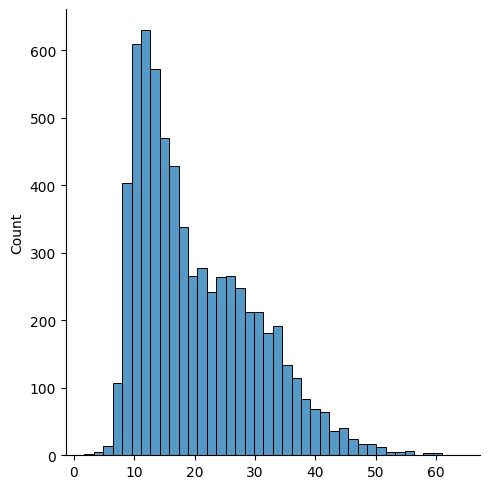

In [56]:
sns.displot(prediction)

In [57]:
submission = pd.DataFrame({"ID_Zindi":id,'GT_NO2':prediction})

In [58]:
submission.to_csv('submission.csv',index=False)